In [2]:
cd /om2/user/leokoz8/code/rnns-of-rnns

/rdma/vast-rdma/vast/fiete/leokoz8/code/rnns-of-rnns


In [3]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.nn import functional as F

from src import models

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [34]:
input_len = 100
input_size = 16
hidden_size = 20
output_size = 10
batch_size = 64

param_dict = {"hidden_size": hidden_size,
             "input_size": input_size,
             "output_size": output_size,
             "nonlinearity": 'relu',
             "gamma": 1,
             "alpha": 0.03}

rnn = models.VanillaRNNDiagonalMetricTorchCell(param_dict)


rnn_out = rnn(inputs)

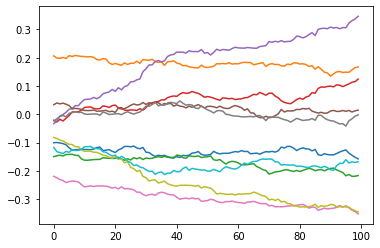

In [39]:
with torch.no_grad():
    plt.plot(rnn_out[1,:,:]);

In [ ]:
#project B so that W = Phi^1 @ B @ Phi is contracting in metric Phi^2


38.0%

100.0%


Extracting ./mnist/MNIST/raw/train-images-idx3-ubyte.gz to ./mnist/MNIST/raw


100.0%


Extracting ./mnist/MNIST/raw/train-labels-idx1-ubyte.gz to ./mnist/MNIST/raw




39.7%

100.0%


Extracting ./mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to ./mnist/MNIST/raw



100.0%

Extracting ./mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./mnist/MNIST/raw




/om/user/leokoz8/envs/rnns-of-rnns-env/lib/python3.8/site-packages/torchvision/datasets/mnist.py:75: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
/om/user/leokoz8/envs/rnns-of-rnns-env/lib/python3.8/site-packages/torchvision/datasets/mnist.py:65: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")


torch.Size([60000, 28, 28])
torch.Size([60000])


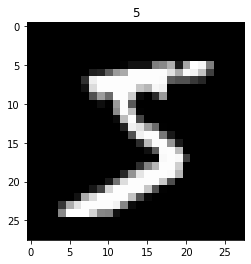

/om/user/leokoz8/envs/rnns-of-rnns-env/lib/python3.8/site-packages/torchvision/datasets/mnist.py:80: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
/om/user/leokoz8/envs/rnns-of-rnns-env/lib/python3.8/site-packages/torchvision/datasets/mnist.py:70: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


In [40]:
import torchvision.datasets as dsets
import torchvision.transforms as transforms

          # learning rate
DOWNLOAD_MNIST = True   # set to True if haven't download the data


# Mnist digital dataset
train_data = dsets.MNIST(
    root='./mnist/',
    train=True,                         # this is training data
    transform=transforms.ToTensor(),    # Converts a PIL.Image or numpy.ndarray to
                                        # torch.FloatTensor of shape (C x H x W) and normalize in the range [0.0, 1.0]
    download=DOWNLOAD_MNIST,            # download it if you don't have it
)

# plot one example
print(train_data.train_data.size())     # (60000, 28, 28)
print(train_data.train_labels.size())   # (60000)
plt.imshow(train_data.train_data[0].numpy(), cmap='gray')
plt.title('%i' % train_data.train_labels[0])
plt.show()

# Data Loader for easy mini-batch return in training
train_loader = torch.utils.data.DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True)

# convert test data into Variable, pick 2000 samples to speed up testing
test_data = dsets.MNIST(root='./mnist/', train=False, transform=transforms.ToTensor())
test_x = test_data.test_data.type(torch.FloatTensor)[:2000]/255.   # shape (2000, 28, 28) value in range(0,1)
test_y = test_data.test_labels.numpy()[:2000]    # covert to numpy array

In [ ]:
# Hyper Parameters
EPOCH = 1             # train the training data n times, to save time, we just train 1 epoch
BATCH_SIZE = 64
TIME_STEP = 28          # rnn time step / image height
INPUT_SIZE = 28         # rnn input size / image width
LR = 0.01     

param_dict = {"hidden_size": 50,
             "input_size": int(28),
             "output_size": 10,
             "nonlinearity": 'relu',
             "gamma": 1,
             "alpha": 0.01}

rnn = models.VanillaRNNDiagonalMetricTorchCell(param_dict)



optimizer = torch.optim.Adam(rnn.parameters(), lr=LR)   # optimize all cnn parameters
loss_func = nn.CrossEntropyLoss()                       # the target label is not one-hotted

# training and testing
for epoch in range(EPOCH):
    #rnn = stabilize_RNN(rnn)
    
    
    
    for step, (b_x, b_y) in enumerate(train_loader):        # gives batch data
        b_x = b_x.view(-1, 28, 28)              # reshape x to (batch, time_step, input_size)

        output = rnn(b_x)                               # rnn output
        loss = loss_func(output[:,-1,:], b_y)                   # cross entropy loss
        optimizer.zero_grad()                           # clear gradients for this training step
        loss.backward()                                 # backpropagation, compute gradients
        optimizer.step()                                # apply gradients

        if step % 50 == 0:
            test_output = rnn(test_x)                   # (samples, time_step, input_size)
            pred_y = torch.max(test_output[:,-1,:], 1)[1].data.numpy()
            accuracy = float((pred_y == test_y).astype(int).sum()) / float(test_y.size)
            print('Epoch: ', epoch, '| train loss: %.4f' % loss.data.numpy(), '| test accuracy: %.2f' % accuracy)

          
# print 10 predictions from test data
test_output = rnn(test_x[:10].view(-1, 28, 28))
pred_y = torch.max(test_output[:,-1,:], 1)[1].data.numpy()
print(pred_y, 'prediction number')
print(test_y[:10], 'real number')

Epoch:  0 | train loss: 2.2914 | test accuracy: 0.12
Epoch:  0 | train loss: 1.8723 | test accuracy: 0.29
Epoch:  0 | train loss: 1.7993 | test accuracy: 0.34
Epoch:  0 | train loss: 1.5971 | test accuracy: 0.38
Epoch:  0 | train loss: 1.7369 | test accuracy: 0.43
Epoch:  0 | train loss: 1.4248 | test accuracy: 0.52
Epoch:  0 | train loss: 1.3307 | test accuracy: 0.52
Epoch:  0 | train loss: 1.2577 | test accuracy: 0.61
Epoch:  0 | train loss: 0.9380 | test accuracy: 0.62
Epoch:  0 | train loss: 0.8506 | test accuracy: 0.66


In [221]:
s = rnn._check_stability(stability_type = 'symmetric')

RNN is provably stable with symmetric condition.
